In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import sqlalchemy
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict
import shap
import sys
import os
module_path = Path("../src/")
os.chdir(module_path)
sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
from data_access.load_file import load_table
from data_processing.functions import time_for_phase, set_end_date
from data_preparation import compute_work_item_times
from data_processing import features
from modeling.evaluation import train_test_predictions, plot_train_test

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

First we load the data with the features we want to have

In [3]:
filename = Path("../data/gdsc2_public.csv")
data = load_table(filename)
times = time_for_phase(data, end_date="2018-03-31")
total_times = compute_work_item_times(set_end_date(data, end_date="2018-03-31"))
work_frequency = features.work_times(times)
is_open = features.is_open(data)
has_loops = features.has_loops(work_frequency)
time_info = features.timestamp_information(total_times, timestamp_col="start", state="start")
time_info2 = features.timestamp_information(total_times, timestamp_col="end", state="end")

Encode the Years of the timestamp information

In [4]:
labelenc = LabelEncoder()
time_info["start_year"] = labelenc.fit_transform(time_info["start_year"])
time_info2["end_year"] = labelenc.fit_transform(time_info2["end_year"])

Set the open work_items end to 0

In [5]:
open_wis = is_open[is_open["is_open"]==1]["work_item"].values
time_info2["end_weekday"].mask(cond=time_info2["work_item"].isin(open_wis), other=0, inplace=True)
time_info2["end_week"].mask(cond=time_info2["work_item"].isin(open_wis), other=0, inplace=True)
time_info2["end_month"].mask(cond=time_info2["work_item"].isin(open_wis), other=0, inplace=True)

Replace multiple phase frequency with 1

In [6]:
work_frequency = work_frequency.set_index("work_item").mask(cond=(lambda x: x>0), other=1).reset_index()

Now we want to add the outlier prediction

In [7]:
filename = Path("../outlier_prediction.csv")
outliers = pd.read_csv(filename)
outliers.rename(columns={"predictions": "outlier_pred"}, inplace=True)

Concat everything into one dataframe

In [8]:
final = reduce(lambda x, y: pd.merge(x, y, on="work_item", how="inner"),
               [work_frequency, time_info, time_info2, is_open, has_loops, outliers])

Add some other features from the raw dataset

In [9]:
cols_to_encode = ["domain", "work_priority", "work_type"]
encode = data[["work_item", *cols_to_encode]].drop_duplicates("work_item")
encoded = pd.get_dummies(encode, columns=cols_to_encode)
final = pd.merge(final, encoded, left_on="work_item", right_on="work_item")

In [10]:
final.drop_duplicates("work_item", inplace=True)
final.set_index("work_item", inplace=True)
final.head()

,Accept_freq,Analyze_freq,Build_freq,Clarify_freq,Deploy_freq,Design_freq,End_freq,Package_freq,Test_freq,start_weekday,...,domain_BD_00010,domain_BD_00011,work_priority_WP_00001,work_priority_WP_00002,work_priority_WP_00003,work_priority_WP_00004,work_priority_WP_00005,work_type_WT_00001,work_type_WT_00002,work_type_WT_00003
work_item,,,,,,,,,,,,,,,,,,,,,
WI_000001,1,1,1,0,1,1,1,1,1,5,...,0,0,0,0,1,0,0,1,0,0
WI_000002,0,1,1,0,0,1,1,0,0,5,...,0,0,0,0,0,1,0,0,1,0
WI_000003,0,1,1,0,0,1,1,1,1,5,...,0,0,0,0,0,1,0,0,1,0
WI_000004,1,1,1,0,1,1,1,1,1,5,...,0,0,0,0,0,1,0,0,1,0
WI_000005,1,1,1,0,1,1,1,0,0,5,...,0,0,0,0,1,0,0,0,1,0


In [11]:
work_times = features.work_times(times, time_col="duration_in_days")

In [12]:
final = final[list(set(final.columns)-set(work_times.set_index("work_item").columns))]
final = pd.merge(final, work_times, on="work_item")

In [13]:
final.drop_duplicates("work_item", inplace=True)
final.set_index("work_item", inplace=True)
final.head()

,end_month,work_priority_WP_00004,end_week,Analyze_freq,has_loops,end_weekday,domain_BD_00002,domain_BD_00003,end_day,start_month,...,domain_BD_00009,Accept,Analyze,Build,Clarify,Deploy,Design,End,Package,Test
work_item,,,,,,,,,,,,,,,,,,,,,
WI_000001,1,0,5,1,1.0,2,0,0,27,1,...,0,1.10,4.82,5.83,0.0,7.02,0.17,0.0,3.91,2.03
WI_000002,1,1,3,1,0.0,3,1,0,14,1,...,0,0.00,11.78,0.00,0.0,0.00,0.00,0.0,0.00,0.00
WI_000003,2,1,9,1,1.0,4,1,0,26,1,...,0,0.00,44.89,0.00,0.0,0.00,6.88,0.0,0.00,3.08
WI_000004,1,1,5,1,0.0,3,1,0,28,1,...,0,2.05,11.80,0.00,0.0,11.89,0.00,0.0,0.00,0.00
WI_000005,2,0,6,1,1.0,3,0,1,4,1,...,0,0.05,25.69,0.98,0.0,6.10,0.03,0.0,0.00,0.00


Now let's split into open and closed items

In [14]:
is_op = final["is_open"]==1
times_open = final[is_op]
times_closed = final[~is_op]
print("We have %i open work_items and %i closed work_items"%(len(times_open), len(times_closed)))

We have 1042 open work_items and 10522 closed work_items


Fine! So what I'm going to do now is predicting the time for every phase regarding to the main/most frequent process. The time as a feature will change in every step the algorithmn take. So we start with first process phase as time feature and the second process phases time as target. We then move the target into the features and predict for the next process phase. In the end we should have 6 models. One for predicting a specific process phase based on already spent time.

In [15]:
freq_cols = ["Analyze_freq", "Design_freq", "Build_freq", "Test_freq", "Package_freq", "Accept_freq", "Deploy_freq", "Clarify_freq"]
time_cols = ["Analyze", "Design", "Build", "Test", "Package", "Accept", "Deploy", "Clarify"]
feature_cols = list(set(times_closed.columns) - set(freq_cols) - set(time_cols) -
           set(["end_month", "end_week", "end_weekday", "is_open", "End_freq", "duration_in_days", "resource_cluster"]))

In [16]:
models = OrderedDict()
for i in range(1, len(freq_cols)):
    print(f"----- Training model for predicting step {freq_cols[i]} -----")
    x_data = times_closed[[*freq_cols[:i], *feature_cols]]
    y_data = times_closed[freq_cols[i:i+1]]
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)
    logres = LogisticRegression(solver='newton-cg')
    fit = logres.fit(x_train, y_train)
    models[freq_cols[i]] = defaultdict(dict)
    models[freq_cols[i]]["model"] = fit
    models[freq_cols[i]]["x_train"] = x_train
    models[freq_cols[i]]["y_train"] = y_train
    models[freq_cols[i]]["x_test"] = x_test
    models[freq_cols[i]]["y_test"] = y_test

----- Training model for predicting step Design_freq -----
----- Training model for predicting step Build_freq -----
----- Training model for predicting step Test_freq -----
----- Training model for predicting step Package_freq -----
----- Training model for predicting step Accept_freq -----
----- Training model for predicting step Deploy_freq -----
----- Training model for predicting step Clarify_freq -----


In [17]:
for key, value in models.items():
    print("The score for predicting " + key + " is: %0.2f"%value["model"].score(value["x_test"], value["y_test"]))

The score for predicting Design_freq is: 0.84
The score for predicting Build_freq is: 0.93
The score for predicting Test_freq is: 0.78
The score for predicting Package_freq is: 0.99
The score for predicting Accept_freq is: 0.86
The score for predicting Deploy_freq is: 0.96
The score for predicting Clarify_freq is: 1.00


Summary of the prediction for Design_freq


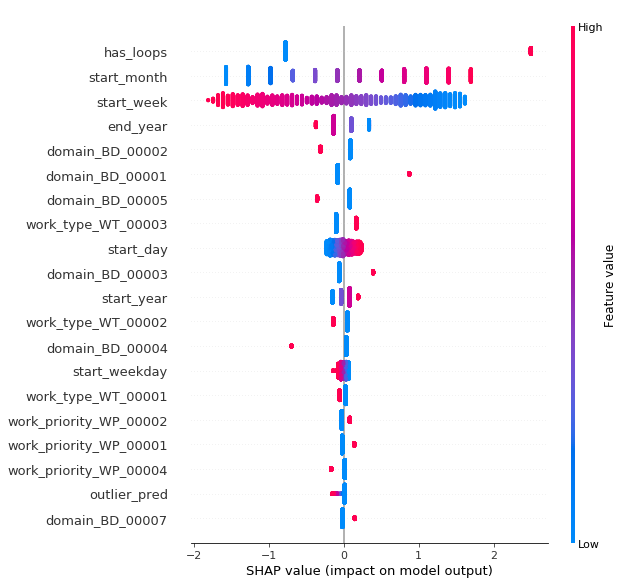

Summary of the prediction for Build_freq


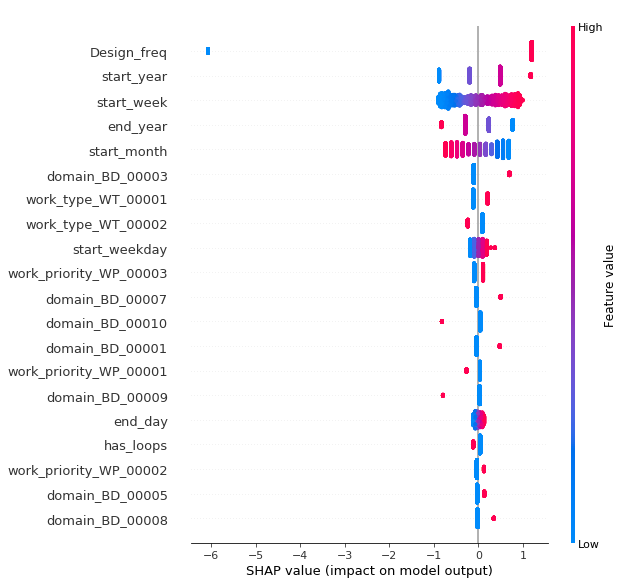

Summary of the prediction for Test_freq


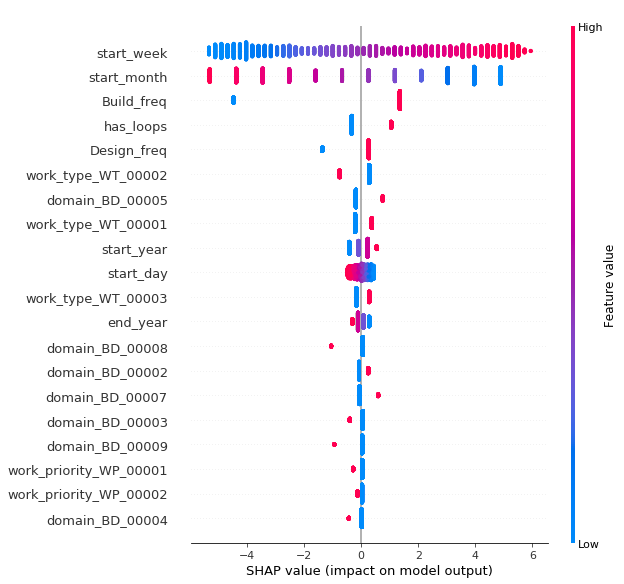

Summary of the prediction for Package_freq


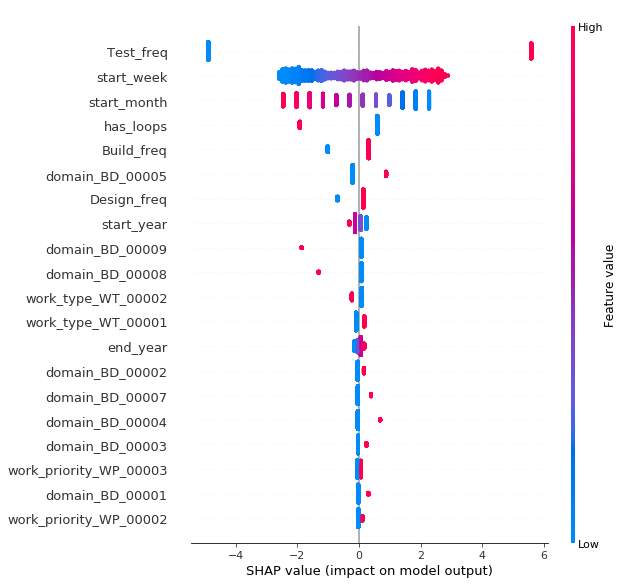

Summary of the prediction for Accept_freq


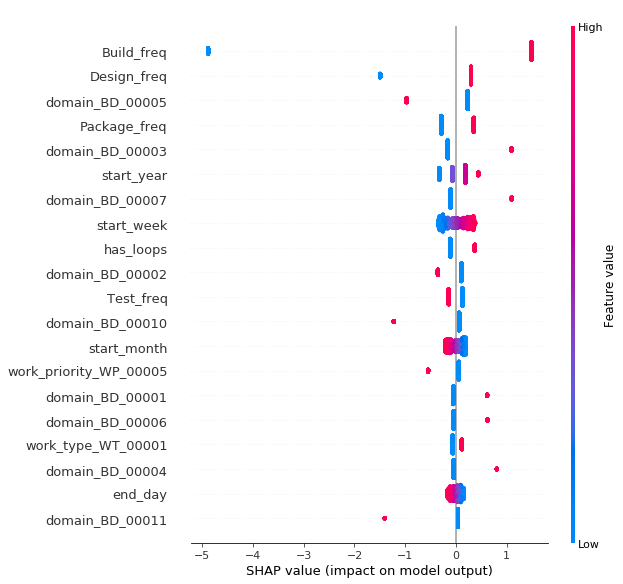

Summary of the prediction for Deploy_freq


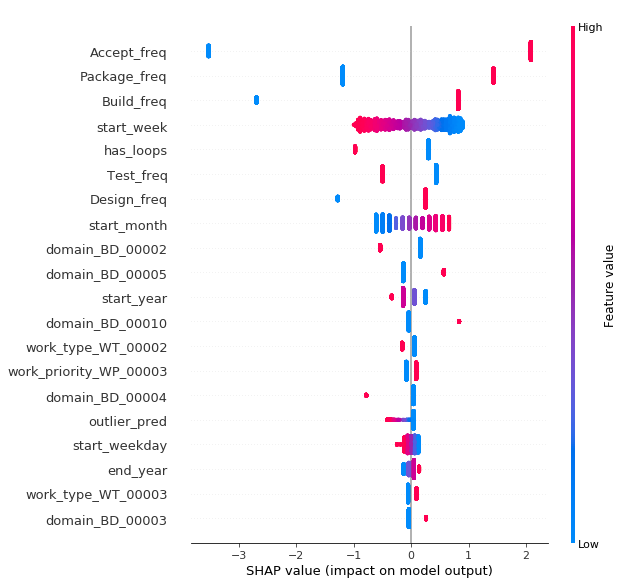

Summary of the prediction for Clarify_freq


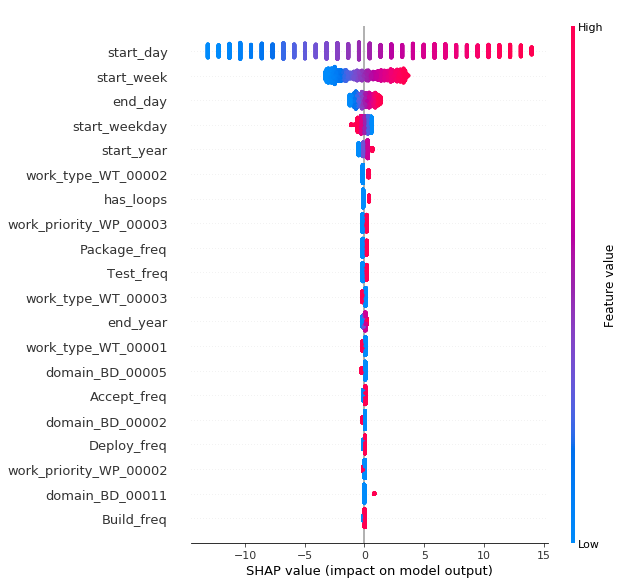

In [18]:
for key, value in models.items():
    print("Summary of the prediction for "+key)
    explainer = shap.LinearExplainer(value["model"], value["x_train"])
    shap_values = explainer.shap_values(value["x_test"])
    shap.summary_plot(shap_values, value["x_test"])
#     plt.figure(figsize=(8,8))
#     plt.scatter(x=value["model"].coef_, y=value["x_train"].columns)
#     plt.title(key)
#     plt.grid()
#     plt.show()

Information of the starting timestamp has the highest impact on the model. We now want to predict a process for the open work items. We will fit every work item in one of the 3 most frequent process paths from notebook 1_process_exploration

In [19]:
predict_df = times_open[[*freq_cols[:1], *feature_cols]]
wis = predict_df.index.values
# Predict for the phase design
key = "Design_freq"
wis = times_open[times_open[key] < 1].index.values
prediction = models[key]["model"].predict_proba(predict_df.loc[wis])
predict_df.loc[:, key] = times_open[key]
predict_df.loc[wis, key] = prediction[:, 1]
predict_df[key].mask(cond=(predict_df[key] >= 0.8), other=1.0, inplace=True)
predict_df[key].mask(cond=(predict_df[key] < 0.8), other=0.0, inplace=True)
# Only predict for the items that are designed
design_wis = predict_df[predict_df[key] >= 1].index.values
# Every Item that is designed is built
key = "Build_freq"
predict_df.loc[:, key] = 0.0
predict_df.loc[design_wis, key] = 1.0
# predict for the Test phase
key = "Test_freq"
wis = times_open[times_open[key] < 1].index.values
test_pred_wis = list(set(design_wis) & set(wis))
prediction = models[key]["model"].predict_proba(predict_df.loc[test_pred_wis, :])
predict_df.loc[:, key] = times_open[key]
predict_df.loc[test_pred_wis, key] = prediction[:, 1]
predict_df[key].mask(cond=(predict_df[key] >= 0.75), other=1.0, inplace=True)
predict_df[key].mask(cond=(predict_df[key] < 0.75), other=0.0, inplace=True)
test_wis = predict_df[predict_df[key] >= 1].index.values
# Every item that has been tested has to be packaged
key = "Package_freq"
predict_df.loc[:, key] = 0.0
predict_df.loc[test_wis, key] = 1.0
# now every item that is designed have to be accepted and deployed
for key in ["Accept_freq", "Deploy_freq"]:
    predict_df.loc[:, key] = 0.0
    predict_df.loc[design_wis, key] = 1.0

In [24]:
predict_df[list(set(freq_cols) - set(["Clarify_freq"]))].head()

,Build_freq,Deploy_freq,Test_freq,Accept_freq,Design_freq,Analyze_freq,Package_freq
work_item,,,,,,,
WI_000165,1.0,1.0,1.0,1.0,1.0,1,1.0
WI_000196,0.0,0.0,0.0,0.0,0.0,1,0.0
WI_000264,0.0,0.0,0.0,0.0,0.0,1,0.0
WI_000273,1.0,1.0,1.0,1.0,1.0,1,1.0
WI_000278,0.0,0.0,0.0,0.0,0.0,1,0.0
